In [13]:
import numpy as np 
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import cross_val_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing, svm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from scipy import stats
from lazypredict.Supervised import LazyRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from joblib import dump

print("done")

done


In [66]:
# #read csv
df = pd.read_csv("CH4_ML_dataset_1d_modis.csv")
# # #filter outlier ch4
df = df[df['CH4_flux'] < 2000]

# #designate chamber data
# # Values to remove
# values_to_remove = ['1', '2', '5', '6']
# # Filter OUT chamber
# df = df[~df['Site'].isin(values_to_remove)]
# Filter TO chamber only
# df = df[df['Site'].isin(values_to_remove)]

# # Group and average data to remove triplicates
df = df.groupby(['Date', 'Site'])[['Latitude', 'Longitude', 'CH4_flux', 'CI', 'Chla.y', 'PAR', 'Kd490', 
                                   'rtoa1', 'rtoa2', 'rtoa3', 'rtoa4', 'rtoa5', 'rtoa6', 'rtoa7', 'rtoa8', 
                                   'rtoa9', 'rtoa10', 'rtoa11', 'rtoa12', 'ADG443', 'TSM', 'pr', 'pr3', 'pr5', 'pr7', 
                                   'tmmx', 'vs', 'water_temp_K']].mean()
df = df.reset_index()

#filter rows where imagery was NA (0)
# Columns to check for 0 values
cols_to_check = ['CI', 'Chla.y', 'PAR', 'Kd490', 'rtoa1', 'rtoa2', 'rtoa3', 'rtoa4', 'rtoa5', 'rtoa6', 'rtoa7', 'rtoa8', 'rtoa9', 'rtoa10', 'rtoa11', 'rtoa12', 'ADG443', 'TSM']

# Identify rows where all specified columns are 0
rows_to_remove = (df[cols_to_check] == 0).all(axis=1)

# Remove the identified rows
df = df[~rows_to_remove]

#create NDCI and MCI
df['NDCI'] = (df['rtoa8'] - df['rtoa11']) / (df['rtoa8'] + df['rtoa11'])

df['MCI'] = df['rtoa11'] - df['rtoa12'] - (df['rtoa10'] - df['rtoa12']) * ((708.75 - 753.75) / (681.25 - 753.75))

#first 5 rows
# df.head()

#num of rows
print(len(df))

#col names
# print(list(df))

#num of NAs
# print(df.isna().sum())


135


In [77]:
#remove 2 NA rows if using PR 5 or 7
df = df.dropna(subset=['pr5', 'NDCI'])

# features = df[['CI', 'Chla.y', 'NDCI', 'MCI', 'PAR', 'Kd490', 'ADG443', 'TSM', 'pr5', 'tmmx', 'vs']]

# feature_names = ['CI', 'Chla.y', 'NDCI', 'MCI', 'PAR', 'Kd490', 'ADG443', 'TSM', 'pr5', 'tmmx', 'vs']

features = df[['CI', 'NDCI', 'MCI', 'pr5', 'vs']]

feature_names = ['CI', 'NCDI', 'MCI', 'pr5', 'vs']

features = features.to_numpy()

ch4 = df[["CH4_flux"]].to_numpy()

#try log transform
ln_ch4 = np.log(ch4)
#fill NAs (negatives) to 0 
ln_ch4 = np.nan_to_num(ln_ch4, nan=0)

site = df[["Site"]].to_numpy()

rs = 621

print(len(features))

121


In [78]:
#%% INITIAL TRAIN-TEST SPLIT (holdout 10% for final training)
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test, site_train, site_test = train_test_split(
    features, ln_ch4, site, test_size = 0.1, random_state = rs)

print(len(x_train))


108


In [ ]:
#lazy regressor analysis of all models
reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
models, predictions = reg.fit(x_train, x_test, y_train, y_test)

print(models)

In [79]:
# Create a Random Forest Regressor model
rf_regressor = RandomForestRegressor(n_estimators=110, random_state= rs)

# Train the model
rf_regressor.fit(x_train, y_train)

# Make predictions on the test set
y_pred = rf_regressor.predict(x_test)

# Evaluate the model using R-squared
rf_r2 = r2_score(y_test, y_pred)
rf_mse = mean_absolute_error(y_test, y_pred)
print(f"RF Mean Absolute Error: {rf_mse}")
print("RF R-squared:", rf_r2)

from sklearn.ensemble import ExtraTreesRegressor
etr = ExtraTreesRegressor(n_estimators=100, random_state=rs)

# Train the model
etr.fit(x_train, y_train)

# Make predictions on the test set
etr_y_pred = etr.predict(x_test)

# Evaluate the model using R-squared
etr_r2 = r2_score(y_test, etr_y_pred)
etr_mse = mean_absolute_error(y_test, etr_y_pred)
print(f"ETR Mean Absolute Error: {etr_mse}")
print("ETR R-squared:", etr_r2)


#XGBR
from xgboost import XGBRegressor

# Initialize the XGBRegressor
xgbr = XGBRegressor(n_estimators=100, random_state=rs)

# Train the model
xgbr.fit(x_train, y_train)

# Make predictions on the test set
xgbr_y_pred = xgbr.predict(x_test)

# Evaluate the model using R-squared and MAE
xgbr_r2 = r2_score(y_test, xgbr_y_pred)
xgbr_mae = mean_absolute_error(y_test, xgbr_y_pred)

print(f"XGBR Mean Absolute Error: {xgbr_mae}")
print("XGBR R-squared:", xgbr_r2)


#dump model for raster testing
# dump(etr, 'etr_example.joblib')

RF Mean Absolute Error: 1.2216774345241317
RF R-squared: 0.08286185705168225
ETR Mean Absolute Error: 1.1053976435285329
ETR R-squared: 0.21877735947053878
XGBR Mean Absolute Error: 1.1936130958797944
XGBR R-squared: -0.01755155215878168


In [80]:
from sklearn.model_selection import RepeatedKFold, cross_validate
from sklearn.metrics import make_scorer, r2_score, mean_absolute_error
import numpy as np

# Repeated K-Fold setup
rkf = RepeatedKFold(n_splits=10, n_repeats=2, random_state=42)

# Cross-validate using multiple scoring metrics
xgbr_cv_results = cross_validate(
    estimator=xgbr,
    X=x_train,
    y=y_train.ravel(),
    cv=rkf,
    scoring={'r2': 'r2', 'mae': 'neg_mean_absolute_error'},
    return_train_score=False,
    n_jobs=-1
)

# Convert negative MAE back to positive
xgbr_r2_scores = xgbr_cv_results['test_r2']
xgbr_mae_scores = -xgbr_cv_results['test_mae']

# Print results
print(f"Repeated XGBR CV Mean R²: {np.mean(xgbr_r2_scores):.4f} ± {np.std(xgbr_r2_scores):.4f}")
print(f"Repeated XGBR CV Max R²: {np.max(xgbr_r2_scores):.4f}")
print(f"Repeated XGBR CV Mean MAE: {np.mean(xgbr_mae_scores):.4f} ± {np.std(xgbr_mae_scores):.4f}")

# Cross-validate using multiple scoring metrics
etr_cv_results = cross_validate(
    estimator=etr,
    X=x_train,
    y=y_train.ravel(),
    cv=rkf,
    scoring={'r2': 'r2', 'mae': 'neg_mean_absolute_error'},
    return_train_score=False,
    n_jobs=-1
)

# Convert negative MAE back to positive
etr_r2_scores = etr_cv_results['test_r2']
etr_mae_scores = -etr_cv_results['test_mae']

# Print results
print(f"Repeated ETR CV Mean R²: {np.mean(etr_r2_scores):.4f} ± {np.std(etr_r2_scores):.4f}")
print(f"Repeated ETR CV Max R²: {np.max(etr_r2_scores):.4f}")
print(f"Repeated ETR CV Mean MAE: {np.mean(etr_mae_scores):.4f} ± {np.std(etr_mae_scores):.4f}")

# Cross-validate using multiple scoring metrics
rf_cv_results = cross_validate(
    estimator=rf_regressor,
    X=x_train,
    y=y_train.ravel(),
    cv=rkf,
    scoring={'r2': 'r2', 'mae': 'neg_mean_absolute_error'},
    return_train_score=False,
    n_jobs=-1
)

# Convert negative MAE back to positive
rf_r2_scores = rf_cv_results['test_r2']
rf_mae_scores = -rf_cv_results['test_mae']

# Print results
print(f"Repeated RF CV Mean R²: {np.mean(rf_r2_scores):.4f} ± {np.std(rf_r2_scores):.4f}")
print(f"Repeated RF CV Max R²: {np.max(rf_r2_scores):.4f}")
print(f"Repeated RF CV Mean MAE: {np.mean(rf_mae_scores):.4f} ± {np.std(rf_mae_scores):.4f}")


Repeated XGBR CV Mean R²: 0.2744 ± 0.4289
Repeated XGBR CV Max R²: 0.8926
Repeated XGBR CV Mean MAE: 1.0247 ± 0.2365
Repeated ETR CV Mean R²: 0.4042 ± 0.2820
Repeated ETR CV Max R²: 0.8930
Repeated ETR CV Mean MAE: 0.9460 ± 0.2274
Repeated RF CV Mean R²: 0.3766 ± 0.3101
Repeated RF CV Max R²: 0.7814
Repeated RF CV Mean MAE: 0.9693 ± 0.1905


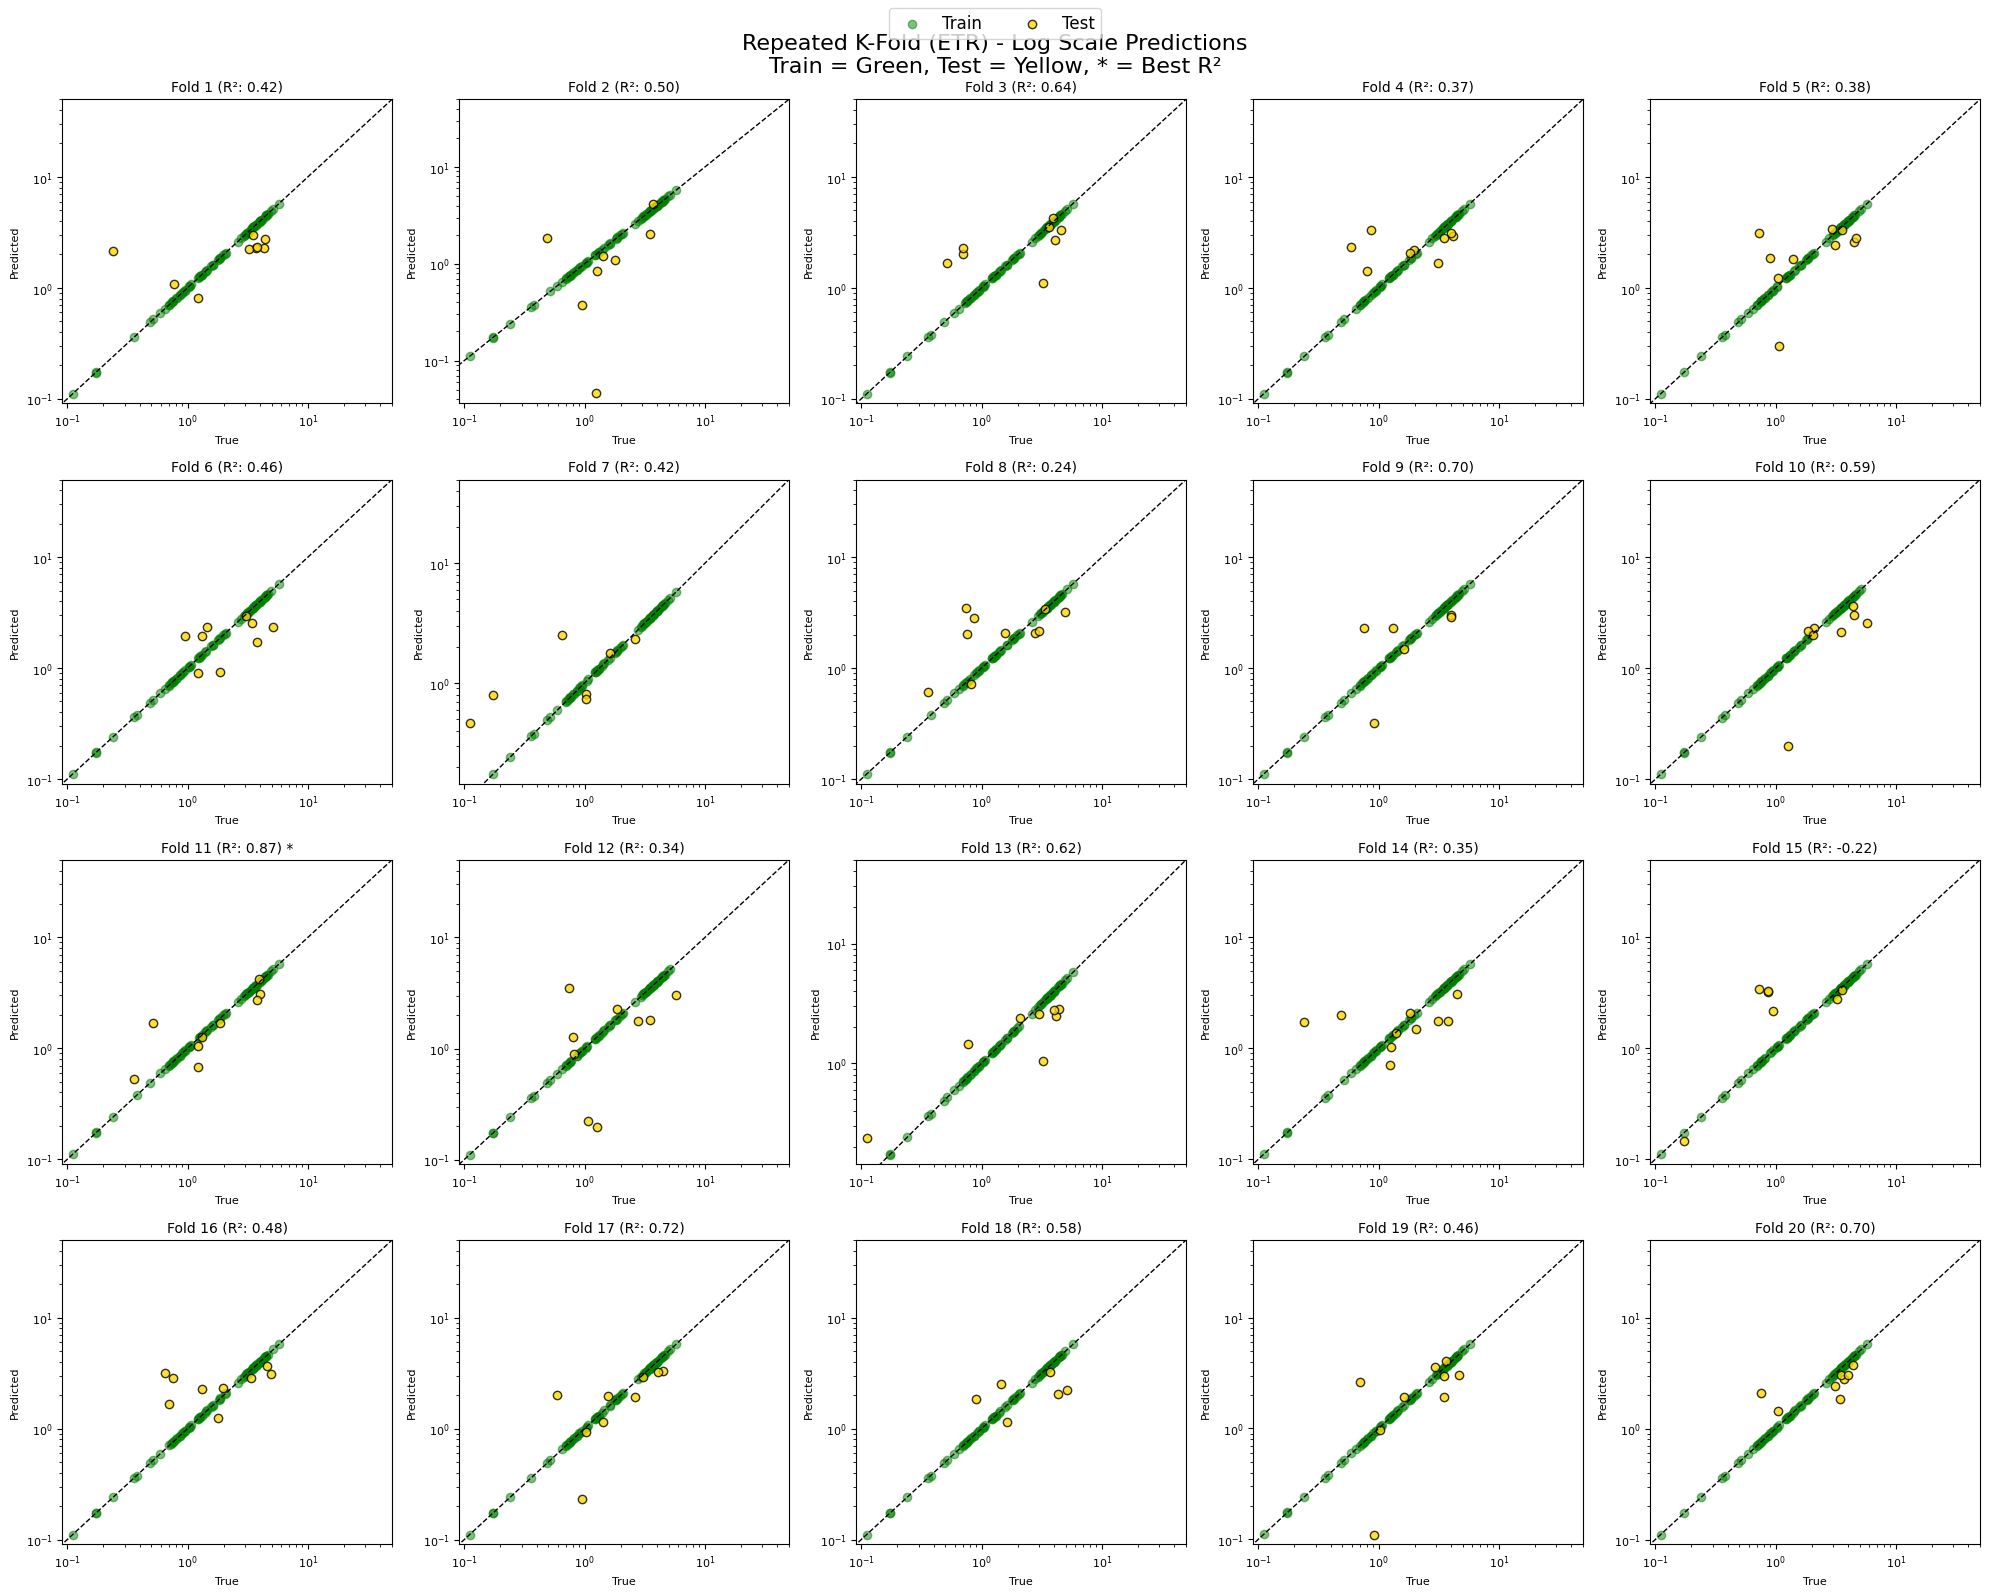

In [46]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import r2_score
from sklearn.base import clone

# Set up Repeated K-Fold
rkf = RepeatedKFold(n_splits=10, n_repeats=2, random_state=42)

# Prepare figure
fig, axes = plt.subplots(4, 5, figsize=(20, 16))
axes = axes.flatten()

r2_scores = []
fold_predictions = []

# Collect all true/predicted values for global axis limits
all_true_vals = []
all_pred_vals = []

# Loop through each fold
for i, (train_idx, test_idx) in enumerate(rkf.split(x_train)):
    X_tr, X_te = x_train[train_idx], x_train[test_idx]
    y_tr, y_te = y_train[train_idx], y_train[test_idx]

    model = clone(etr)
    model.fit(X_tr, y_tr.ravel())

    y_tr_pred = model.predict(X_tr)
    y_te_pred = model.predict(X_te)

    r2 = r2_score(y_te, y_te_pred)
    r2_scores.append(r2)
    fold_predictions.append((y_tr, y_tr_pred, y_te, y_te_pred))

    # Flatten before collecting to avoid dimension mismatch
    all_true_vals.extend(y_tr.ravel())
    all_true_vals.extend(y_te.ravel())
    all_pred_vals.extend(np.ravel(y_tr_pred))
    all_pred_vals.extend(np.ravel(y_te_pred))

# Determine best fold by R²
best_idx = np.argmax(r2_scores)

# Filter out zeros and negatives for log scale
combined_vals = np.concatenate([all_true_vals, all_pred_vals])
combined_vals = combined_vals[combined_vals > 0]
min_val, max_val = combined_vals.min(), combined_vals.max()

# Plot each fold
for i, (y_tr, y_tr_pred, y_te, y_te_pred) in enumerate(fold_predictions):
    ax = axes[i]
    ax.scatter(y_tr, y_tr_pred, color='green', alpha=0.5, label='Train')
    ax.scatter(y_te, y_te_pred, color='gold', edgecolor='black', alpha=0.8, label='Test')

    # Set log scale and global limits
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(0, 50)
    ax.set_ylim(0, 50)

    # 1:1 reference line
    ax.plot([0, 50], [0, 50], 'k--', lw=1)

    # Title with R² and asterisk for best fold
    title = f"Fold {i+1} (R²: {r2_scores[i]:.2f})"
    if i == best_idx:
        title += " *"
    ax.set_title(title, fontsize=10)

    ax.set_xlabel("True", fontsize=8)
    ax.set_ylabel("Predicted", fontsize=8)
    ax.tick_params(axis='both', which='both', labelsize=8)

# Add legend only once
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=2, fontsize=12)

fig.tight_layout(rect=[0, 0, 1, 0.96])
fig.suptitle("Repeated K-Fold (ETR) - Log Scale Predictions\nTrain = Green, Test = Yellow, * = Best R²", fontsize=16)
plt.show()


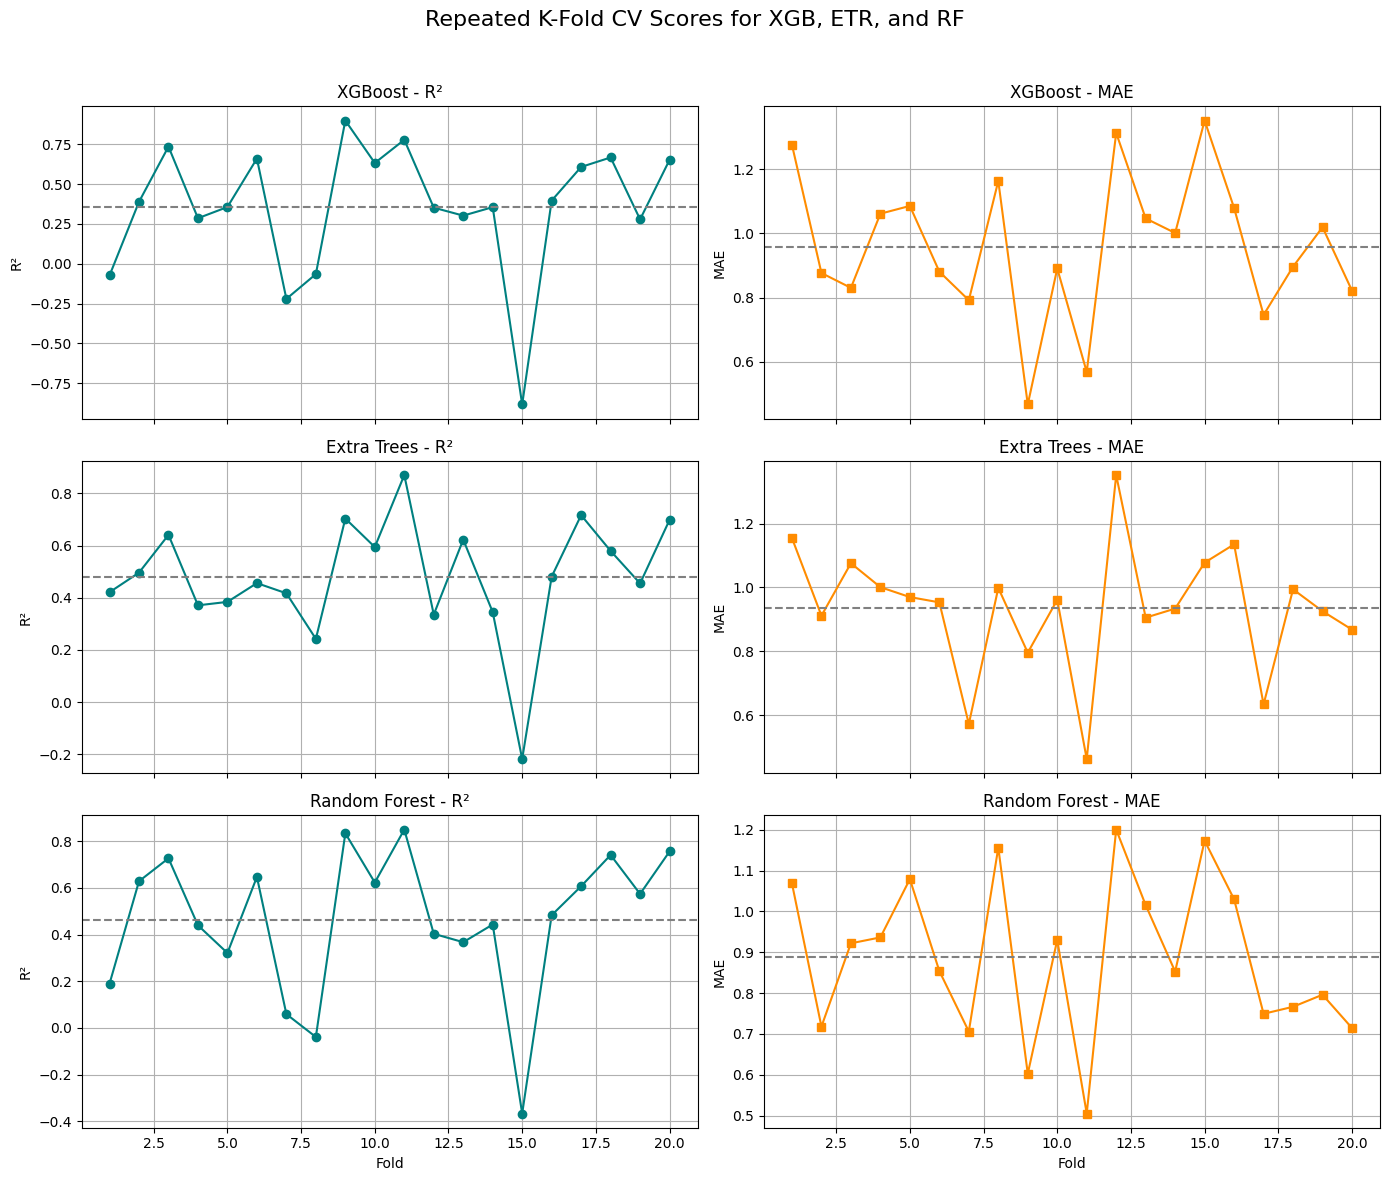

In [47]:
import matplotlib.pyplot as plt
import numpy as np

# Fold index array
folds = np.arange(1, len(xgbr_r2_scores) + 1)

# Set up the figure
fig, axes = plt.subplots(3, 2, figsize=(14, 12), sharex=True)
fig.suptitle("Repeated K-Fold CV Scores for XGB, ETR, and RF", fontsize=16)

# ---- XGBoost ----
axes[0, 0].plot(folds, xgbr_r2_scores, 'o-', color='teal')
axes[0, 0].axhline(np.mean(xgbr_r2_scores), color='gray', linestyle='--')
axes[0, 0].set_title("XGBoost - R²")
axes[0, 0].set_ylabel("R²")
axes[0, 0].grid(True)

axes[0, 1].plot(folds, xgbr_mae_scores, 's-', color='darkorange')
axes[0, 1].axhline(np.mean(xgbr_mae_scores), color='gray', linestyle='--')
axes[0, 1].set_title("XGBoost - MAE")
axes[0, 1].set_ylabel("MAE")
axes[0, 1].grid(True)

# ---- Extra Trees ----
axes[1, 0].plot(folds, etr_r2_scores, 'o-', color='teal')
axes[1, 0].axhline(np.mean(etr_r2_scores), color='gray', linestyle='--')
axes[1, 0].set_title("Extra Trees - R²")
axes[1, 0].set_ylabel("R²")
axes[1, 0].grid(True)

axes[1, 1].plot(folds, etr_mae_scores, 's-', color='darkorange')
axes[1, 1].axhline(np.mean(etr_mae_scores), color='gray', linestyle='--')
axes[1, 1].set_title("Extra Trees - MAE")
axes[1, 1].set_ylabel("MAE")
axes[1, 1].grid(True)

# ---- Random Forest ----
axes[2, 0].plot(folds, rf_r2_scores, 'o-', color='teal')
axes[2, 0].axhline(np.mean(rf_r2_scores), color='gray', linestyle='--')
axes[2, 0].set_title("Random Forest - R²")
axes[2, 0].set_xlabel("Fold")
axes[2, 0].set_ylabel("R²")
axes[2, 0].grid(True)

axes[2, 1].plot(folds, rf_mae_scores, 's-', color='darkorange')
axes[2, 1].axhline(np.mean(rf_mae_scores), color='gray', linestyle='--')
axes[2, 1].set_title("Random Forest - MAE")
axes[2, 1].set_xlabel("Fold")
axes[2, 1].set_ylabel("MAE")
axes[2, 1].grid(True)

# Layout
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()



In [ ]:
# Tuning XGBR
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for XGBoost
param_grid = {
    'n_estimators': [int(x) for x in np.linspace(100, 1500, 10)],
    'max_depth': [int(x) for x in np.linspace(3, 30, 10)],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'subsample': [0.6, 0.8, 1.0]
}

# Define scoring metrics
scoring = {
    "R2": "r2", 
    "MAE": "neg_mean_absolute_error", 
    "MAPE": "neg_mean_absolute_percentage_error"
}

# Base model
xgbr = XGBRegressor(objective='reg:squarederror', random_state=rs)

# K-Fold setup
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Grid Search
xgbr_random = GridSearchCV(
    estimator=xgbr,
    param_grid=param_grid,   # Same param grid as before
    cv=kf,
    verbose=2,
    scoring=scoring,
    refit="MAE",
    n_jobs=-1
)

# Fit it
xgbr_random.fit(x_train, y_train.ravel())

# Best parameters
print("Best Parameters:\n", xgbr_random.best_params_)


In [58]:
#Best XGBR
# Initialize the XGBRegressor
# Create a new model using the best parameters from the search

#from GridSearch
# Best Parameters:
#  {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100, 'subsample': 0.8}
best_xgbr = XGBRegressor(**xgbr_random.best_params_, objective='reg:squarederror', random_state=rs)

# Fit the model (optional, if you want to retrain it cleanly)
best_xgbr.fit(x_train, y_train.ravel())

# Make predictions on the test set
xgbr_y_pred = best_xgbr.predict(x_test)

# Evaluate the model using R-squared and MAE
xgbr_r2 = r2_score(y_test, xgbr_y_pred)
xgbr_mae = mean_absolute_error(y_test, xgbr_y_pred)

print(f"XGBR Mean Absolute Error: {xgbr_mae}")
print("XGBR R-squared:", xgbr_r2)

XGBR Mean Absolute Error: 14.988765425766658
XGBR R-squared: 0.395318365067193


In [ ]:
# Hyperparameter tuning
#%% RANDOM SEARCH CV ETR
from sklearn.model_selection import RandomizedSearchCV

#define scoring metrics
scoring = {"R2": "r2", 
           "MAE": "neg_mean_absolute_error", 
           "MAPE": "neg_mean_absolute_percentage_error"}


# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1500, num = 10)]
# Number of features to consider at every split
max_features = ['log2', 'sqrt', 1.0]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 4, 7, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 7, 10]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
# pprint(random_grid)

# Use the random grid to search for best hyperparameters
# First create the base model to tune
etr = ExtraTreesRegressor()

#K fold
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
etr_random = RandomizedSearchCV(estimator = etr, 
                               param_distributions = random_grid, 
                               n_iter = 500, cv = kf, 
                               verbose=2, scoring = scoring,
                                refit = "MAE",
                               random_state=rs, n_jobs = -1)

# Fit the random search model
etr_random.fit(x_train, y_train.ravel())

#%%
etr_random.best_params_

In [59]:
# Best ETR
# Create an Extra Trees Regressor model
best_etr = ExtraTreesRegressor(n_estimators=1033, 
                          min_samples_split = 4,
                          min_samples_leaf = 1,
                          max_features = 'log2',
                          max_depth = 10,
                          random_state=rs)

# Train the model
best_etr.fit(x_train, y_train)

# Make predictions on the test set
y_pred = best_etr.predict(x_test)

# Evaluate the model
etr_mse = mean_absolute_error(y_test, y_pred)
etr_r2 = r2_score(y_test, y_pred)
print(f"ETR Mean Absolute Error: {etr_mse}")
print("ETR R-squared:", etr_r2)

ETR Mean Absolute Error: 14.997871591573173
ETR R-squared: 0.28585648710897216


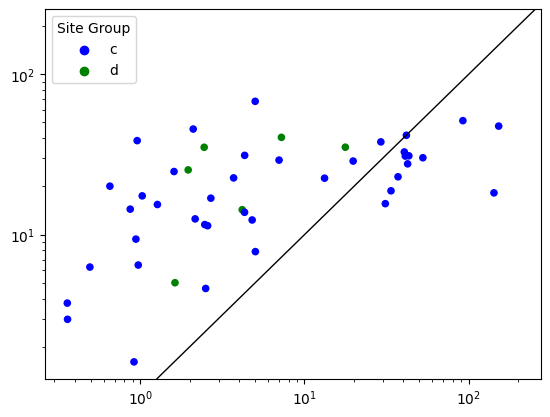

In [43]:
# Error analysis
preds = pd.DataFrame(y_pred, columns=['etr_pred_ch4'])
obs = pd.DataFrame(y_test, columns=['ch4'])
test_features = pd.DataFrame(x_test, columns=feature_names)

error_df = pd.concat([obs.reset_index(drop=True), preds], axis=1)
error_df = pd.concat([test_features.reset_index(drop=True), error_df], axis=1)

site_names = pd.DataFrame(site_test, columns=["Site"]) 
error_df = pd.concat([site_names.reset_index(drop=True), error_df], axis=1)

# Add a column for site group names
error_df["site_group"] = np.where(error_df["Site"].isin(["1", "2", "5", "6"]), "c", "d")

# Map site_group to color
color_map = {'c': 'blue', 'd': 'green'}
colors = error_df['site_group'].map(color_map)

plt.scatter(error_df['ch4'], error_df['etr_pred_ch4'], s=20, c=colors)
plt.axline((0, 0), (200, 200), linewidth=1, color='black')
plt.xscale('log')
plt.yscale('log')

# Optional: add legend manually
for group in color_map:
    plt.scatter([], [], c=color_map[group], label=group)
plt.legend(title='Site Group')

plt.show()

Exception ignored in: <function tqdm.__del__ at 0x119cd7c40>
Traceback (most recent call last):
  File "/Users/jilliangreene/grad_school/sentinel3_ch4_model/venv/lib/python3.12/site-packages/tqdm/std.py", line 1148, in __del__
    self.close()
  File "/Users/jilliangreene/grad_school/sentinel3_ch4_model/venv/lib/python3.12/site-packages/tqdm/notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
    ^^^^^^^^^
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


Text(0.5, 1.0, 'ETR')

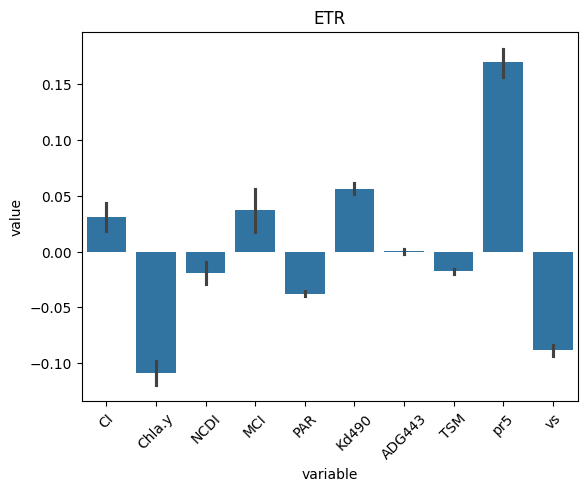

In [72]:
#%% FEATURE IMPORTANCE 
from sklearn.inspection import permutation_importance
import seaborn as sns

scoring = {"R2": "r2", 
           "MAE": "neg_mean_absolute_error", 
           "MAPE": "neg_mean_absolute_percentage_error"}

result = permutation_importance(
    etr, x_test, y_test,
    n_repeats=500, 
    random_state=rs, 
    n_jobs=-1,
    scoring=scoring)

#%% Plot RF importances
rf_perm_imp = pd.DataFrame(result['MAE']['importances'], index=feature_names).T

perm_imp_long = pd.melt(rf_perm_imp)
g = sns.barplot(data = perm_imp_long, x = 'variable',y='value')
plt.xticks(rotation=45)
plt.title("ETR")

Text(0.5, 1.0, 'ETR - Discrete Only')

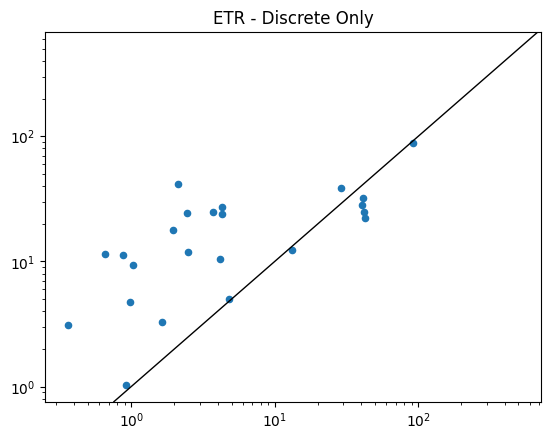

In [138]:
#%% PLOT BEST ETR PERFORMANCE
#https://stackoverflow.com/questions/19064772/visualization-of-scatter-plots-with-overlapping-points-in-matplotlib
from scipy import stats

values = np.vstack([y_test.ravel(), y_pred.ravel()])
kernel = stats.gaussian_kde(values, bw_method=.02)(values)

plt.scatter(y_test, y_pred, s=20)
plt.axline((0,0), (500,500), linewidth=1, color='black')
# plt.axis((0,50,0,50))
plt.xscale('log')
plt.yscale('log')
plt.title("ETR - Discrete Only")

# plt.savefig('log_randomforest_plot.png')

In [ ]:
# #write obs vs pred to csv for manual stat calc
best_rf_csv = pd.DataFrame(y_pred, columns=['pred_ch4'])
y_test_csv = pd.DataFrame(y_test, columns=['ch4'])
best_rf_csv = pd.concat([y_test_csv.reset_index(drop=True), best_rf_csv], axis=1)

best_rf_csv.to_csv('etr_obs_vs_pred.csv', index = False)